# Alphalens Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet, create_returns_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
idx = pd.IndexSlice

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

In [5]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [6]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'finance_datareader/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [7]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

In [8]:
def get_factor(predictions):
    return (predictions.unstack('symbol')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())    

## Linear Regression

In [9]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       symbol
2014-11-12 00:00:00+00:00  000120    0.006617
                           000210    0.005644
                           000660   -0.001250
                           000720    0.003164
                           000810    0.004416
dtype: float64

In [10]:
tickers = lr_factor.index.get_level_values('symbol').unique()

In [11]:
trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 982 entries, 2014-01-02 00:00:00+00:00 to 2017-12-28 00:00:00+00:00
Columns: 306 entries, 000120 to 007460
dtypes: float64(306)
memory usage: 2.3 MB


In [12]:
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73726 entries, (Timestamp('2014-11-12 00:00:00+0000', tz='UTC', freq='C'), '000120') to (Timestamp('2017-11-28 00:00:00+0000', tz='UTC', freq='C'), '204320')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               73726 non-null  float64
 1   5D               73726 non-null  float64
 2   10D              73726 non-null  float64
 3   21D              73726 non-null  float64
 4   factor           73726 non-null  float64
 5   factor_quantile  73726 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.239067,0.018257,-0.006890,0.008843,14991,20.333397
2,-0.014865,0.021003,-0.001779,0.004419,14690,19.925128
3,-0.012029,0.024828,0.000296,0.004452,14419,19.557551
4,-0.009606,0.028878,0.002442,0.004566,14690,19.925128
5,-0.006947,0.186421,0.007308,0.009497,14936,20.258796


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.309,0.221,0.150,0.122
beta,-0.054,-0.002,-0.056,-0.056
Mean Period Wise Return Top Quantile (bps),9.394,4.245,2.161,2.258
Mean Period Wise Return Bottom Quantile (bps),-12.097,-8.084,-6.329,-6.114
Mean Period Wise Spread (bps),21.491,12.414,8.559,8.383


Information Analysis


,1D,5D,10D,21D
IC Mean,0.030,0.035,0.029,0.031
IC Std.,0.134,0.138,0.137,0.130
Risk-Adjusted IC,0.225,0.252,0.214,0.238
t-stat(IC),6.160,6.889,5.853,6.514
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,0.074,0.169,0.086,0.052
IC Kurtosis,-0.053,-0.352,-0.513,-0.296


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.277,0.493,0.626,0.745
Quantile 2 Mean Turnover,0.493,0.660,0.724,0.775
Quantile 3 Mean Turnover,0.544,0.701,0.755,0.795
Quantile 4 Mean Turnover,0.488,0.658,0.718,0.769
Quantile 5 Mean Turnover,0.250,0.445,0.569,0.696


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.861,0.653,0.499,0.342


<Figure size 432x288 with 0 Axes>

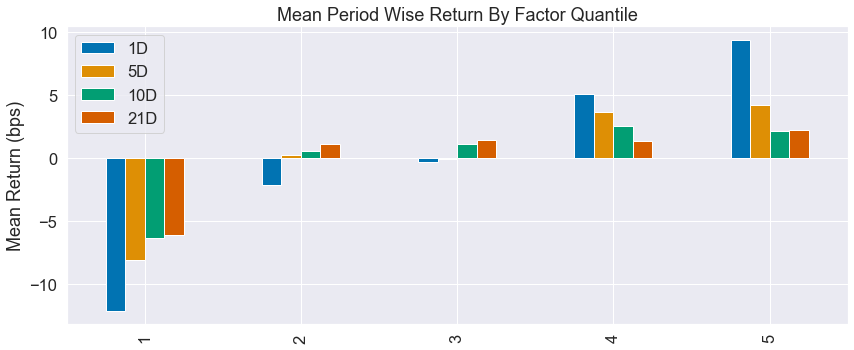

In [13]:
create_summary_tear_sheet(lr_factor_data);

## Ridge Regression

In [14]:
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [15]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-11-12 00:00:00+00:00  000120    0.000893
                           000210    0.000672
                           000660    0.000519
                           000720    0.000196
                           000810    0.000746
dtype: float64

In [16]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73726 entries, (Timestamp('2014-11-12 00:00:00+0000', tz='UTC', freq='C'), '000120') to (Timestamp('2017-11-28 00:00:00+0000', tz='UTC', freq='C'), '204320')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               73726 non-null  float64
 1   5D               73726 non-null  float64
 2   10D              73726 non-null  float64
 3   21D              73726 non-null  float64
 4   factor           73726 non-null  float64
 5   factor_quantile  73726 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.027612,0.002017,-0.000882,0.001183,14991,20.333397
2,-0.001734,0.002307,-0.000192,0.000455,14690,19.925128
3,-0.001232,0.002512,0.000061,0.000445,14419,19.557551
4,-0.000988,0.002831,0.000295,0.000453,14690,19.925128
5,-0.000773,0.022809,0.000770,0.000989,14936,20.258796


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.260,0.218,0.182,0.166
beta,-0.020,0.005,-0.035,0.050
Mean Period Wise Return Top Quantile (bps),8.729,3.599,3.320,3.438
Mean Period Wise Return Bottom Quantile (bps),-11.656,-8.139,-7.809,-7.396
Mean Period Wise Spread (bps),20.385,11.789,11.202,10.898


Information Analysis


,1D,5D,10D,21D
IC Mean,0.041,0.047,0.052,0.060
IC Std.,0.164,0.153,0.156,0.161
Risk-Adjusted IC,0.253,0.303,0.335,0.376
t-stat(IC),6.927,8.310,9.184,10.297
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-0.104,0.027,-0.018,-0.213
IC Kurtosis,-0.019,-0.334,-0.506,0.355


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.236,0.467,0.618,0.764
Quantile 2 Mean Turnover,0.441,0.654,0.740,0.790
Quantile 3 Mean Turnover,0.494,0.697,0.767,0.802
Quantile 4 Mean Turnover,0.449,0.655,0.727,0.768
Quantile 5 Mean Turnover,0.238,0.451,0.587,0.718


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.884,0.668,0.484,0.272


<Figure size 432x288 with 0 Axes>

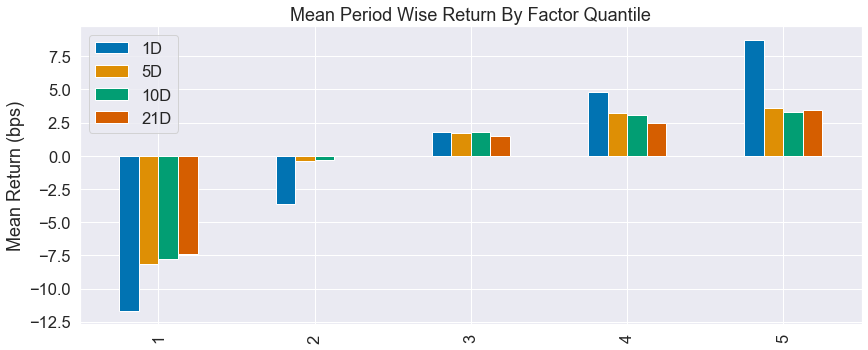

In [17]:
create_summary_tear_sheet(ridge_factor_data);

## Lasso Regression

In [18]:
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [19]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

date                       symbol
2014-11-12 00:00:00+00:00  000120    0.000959
                           000210    0.000959
                           000660    0.000959
                           000720    0.000959
                           000810    0.000959
dtype: float64

In [28]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

Dropped 4.0% entries from factor data: 0.0% in forward returns computation and 4.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 70809 entries, (Timestamp('2014-11-26 00:00:00+0000', tz='UTC', freq='C'), '000120') to (Timestamp('2017-11-28 00:00:00+0000', tz='UTC', freq='C'), '204320')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               70809 non-null  float64
 1   5D               70809 non-null  float64
 2   10D              70809 non-null  float64
 3   21D              70809 non-null  float64
 4   factor           70809 non-null  float64
 5   factor_quantile  70809 non-null  float64
dtypes: float64(6)
memory usage: 3.5+ MB


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.310,0.233,0.189,0.135
beta,0.054,0.039,-0.015,-0.020
Mean Period Wise Return Top Quantile (bps),10.521,4.683,4.252,4.343
Mean Period Wise Return Bottom Quantile (bps),-13.881,-8.298,-7.815,-7.675
Mean Period Wise Spread (bps),24.402,13.103,12.183,12.170


<Figure size 432x288 with 0 Axes>

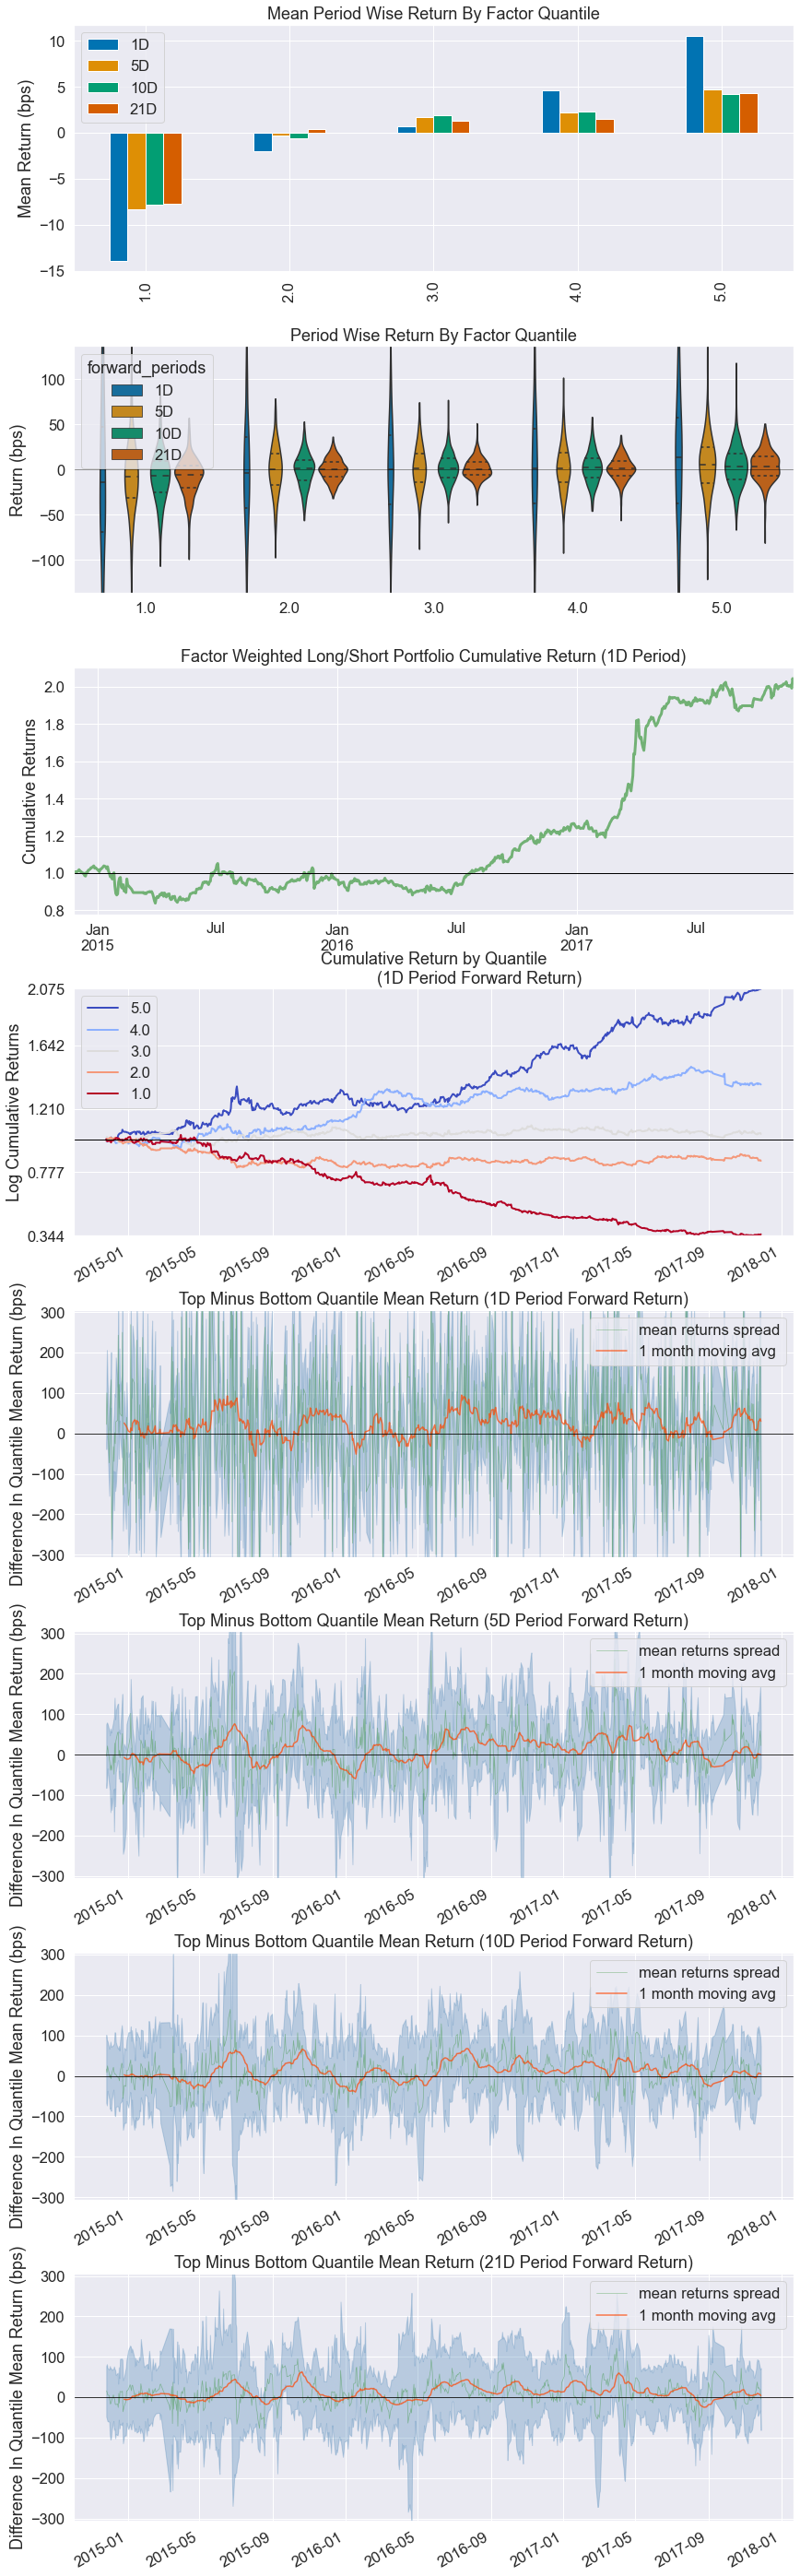

In [34]:
create_returns_tear_sheet(lasso_factor_data);